In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import json
import os
from typing import Dict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors  # type: ignore
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.QED import qed
from rdkit.Contrib.SA_Score import sascorer
from tqdm import tqdm

from divopt.evaluation.process_results import get_sorted_optimizers, get_virtual_screening_name
from divopt.utils import list_cache, pool_wrapper

In [4]:
from divopt.evaluation.process_results import load_results

runs_base = "../runs"
limit_names = ["samples", "time"]
results_dict = load_results(runs_base)

sorted_optimizers_dict = {}
for limit_name in limit_names:
    results = results_dict[limit_name]
    sorted_optimizers = get_sorted_optimizers(results, limit_name)
    sorted_optimizers_dict[limit_name] = sorted_optimizers

In [5]:
known_bits_fname = "../data/scoring_functions/guacamol_known_bits.json"
with open(known_bits_fname) as f:
    known_bits = json.load(f)
known_bits = set(known_bits)

new_names_dict = {
    "GA": "GraphGA",
    "BestAgentReminder": "BAR",
    "AugHC": "AugmentedHC",
}


# load property thresholds
threshold_fname = "../data/scoring_functions/guacamol_thresholds.json"
with open(threshold_fname) as f:
    property_thresholds = json.load(f)

property_thresholds["fraction_known_bits"] = property_thresholds["ECFP4bits"]
del property_thresholds["ECFP4bits"]
del property_thresholds["QED"]

property_thresholds["fraction_known_bits"] = [0, 1 - property_thresholds["fraction_known_bits"][0]]
property_thresholds

{'MW': [157.11027872, 761.3414418201],
 'LogP': [-2.0107999999999997, 8.831511500000007],
 'fraction_known_bits': [0, 0.08333333333333337]}

In [6]:
def calculate_properties(smiles) -> Dict[str, float]:
    props = {}
    mol = Chem.MolFromSmiles(smiles)
    props["QED"] = qed(mol)
    props["MW"] = ExactMolWt(mol)
    props["LogP"] = MolLogP(mol)
    props["SmilesLength"] = len(smiles)
    props["SA"] = sascorer.calculateScore(mol)
    # morgan fingerprint from rdkit
    fp = rdMolDescriptors.GetMorganFingerprint(mol, 2)
    compound_bits = set(fp.GetNonzeroElements().keys())
    props["fraction_known_bits"] = len(compound_bits.intersection(known_bits)) / len(compound_bits)
    return props

In [7]:
calculate_properties_list = list_cache(pool_wrapper(calculate_properties))

In [8]:
def process_rundir(run_dir, limit_name):
    results_fname = f"results_diverse_all_{limit_name}.csv"
    config_fname = "config.json"

    with open(os.path.join(run_dir, config_fname)) as f:
        config = json.load(f)
    df = pd.read_csv(os.path.join(run_dir, results_fname))

    smiles_list = df["CanSmiles"].unique().tolist()
    df_prop = pd.DataFrame(calculate_properties_list(smiles_list))

    optimizer_name_raw = config["optimizer_name"]
    if optimizer_name_raw == "VS":
        optimizer_name = get_virtual_screening_name(config["optimizer_args"]["smiles_file"])
    elif optimizer_name_raw in new_names_dict:
        optimizer_name = new_names_dict[optimizer_name_raw]
    else:
        optimizer_name = optimizer_name_raw

    df_prop["Optimizer"] = optimizer_name
    df_prop["Task"] = config["scoring_function_name"]
    return df_prop

In [9]:
def compute_property_df(runs_base, limit_name: str) -> pd.DataFrame:
    study_dir = os.path.join(runs_base, f"best_variance_{limit_name}")
    virtual_screening_dirs = glob.glob(os.path.join(runs_base, "virtual_screening", "*"))

    run_dirs = glob.glob(os.path.join(study_dir, "*")) + virtual_screening_dirs

    properties_fname = os.path.join(study_dir, f"properties_{limit_name}.csv")

    if os.path.exists(properties_fname):
        print(f"Loading {properties_fname}")
        df_prop = pd.read_csv(properties_fname)
    else:
        print(properties_fname)
        df_prop_list = []
        for run_dir in tqdm(run_dirs):
            try:
                df_prop_list.append(process_rundir(run_dir, limit_name))
            except FileNotFoundError:
                print(f"Skipping {run_dir}")
        df_prop = pd.concat(df_prop_list)
        df_prop.to_csv(properties_fname, index=False)

    return df_prop

In [10]:
df_prop_dict = {}
for limit_name in limit_names:
    df_prop_dict[limit_name] = compute_property_df(runs_base, limit_name)

Loading ../runs/best_variance_samples/properties_samples.csv
Loading ../runs/best_variance_time/properties_time.csv


In [11]:
# convert known bits to fraction unknown bits
for limit_name in limit_names:
    r = df_prop_dict[limit_name]
    fkb = r["fraction_known_bits"]
    if fkb.mean() > 0.5:
        fkb = 1 - fkb
        r["fraction_known_bits"] = fkb

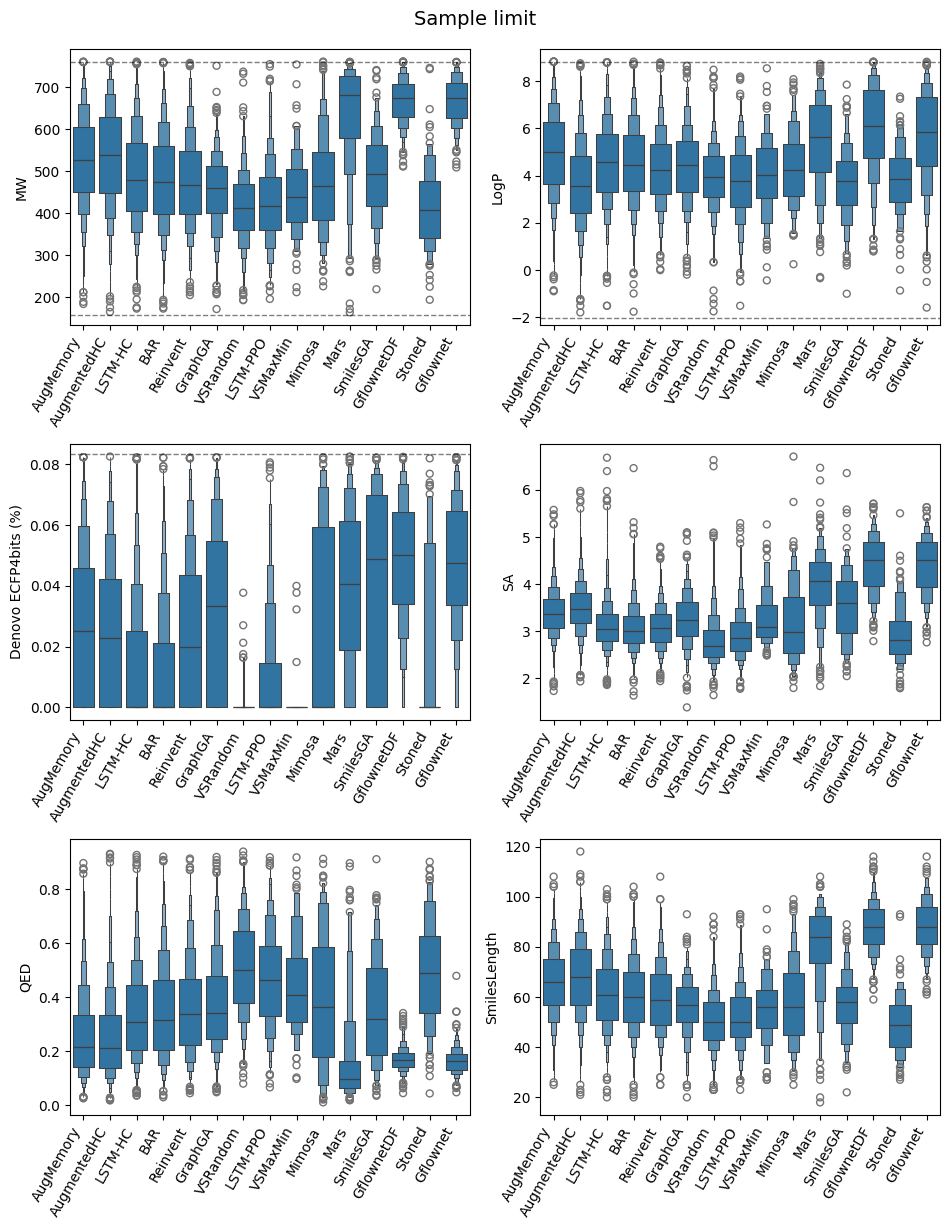

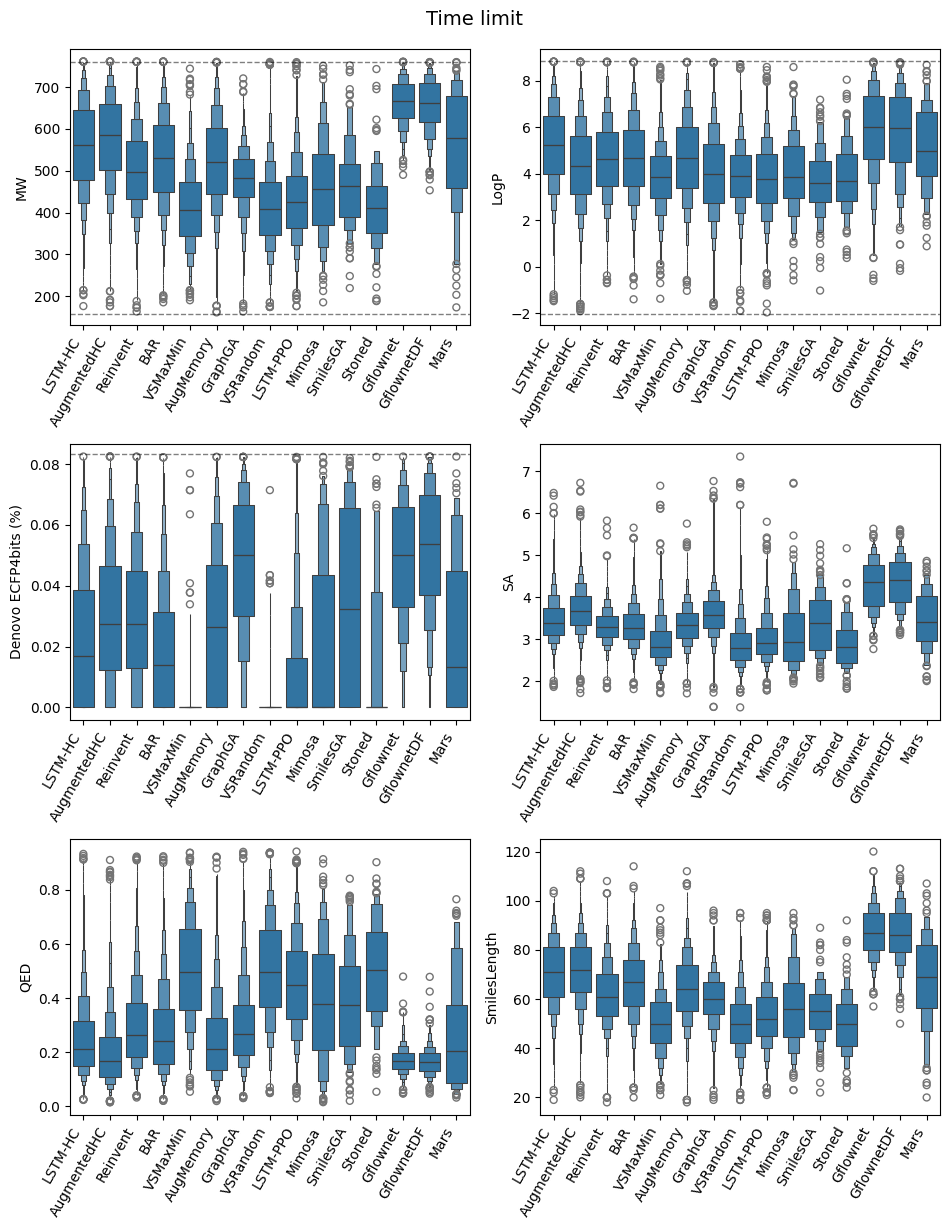

In [12]:
title_dict = {"samples": "Sample limit", "time": "Time limit"}


def plot_properties(df_prop: pd.DataFrame, limit_name: str) -> None:
    property_names = ["MW", "LogP", "fraction_known_bits", "SA", "QED", "SmilesLength"]
    new_property_names = {"fraction_known_bits": "Denovo ECFP4bits (%)"}

    nrows = 3
    n_cols = 2

    assert len(property_names) == nrows * n_cols
    # fig, axes = plt.figure(nfigsize=(4*n_cols, 4*nrows))
    fig, axes = plt.subplots(nrows=nrows, ncols=n_cols, figsize=(4.8 * n_cols, 4 * nrows), sharex=False)
    for i, property_name in enumerate(property_names):
        ax = axes[i // n_cols, i % n_cols]

        sorted_optimizers = sorted_optimizers_dict[limit_name]
        sns.boxenplot(x="Optimizer", y=property_name, data=df_prop, order=sorted_optimizers, ax=ax)
        if property_name in property_thresholds:
            ax.axhline(property_thresholds[property_name][1], ls="--", color="black", alpha=0.5, lw=1)
            if property_name != "fraction_known_bits":
                ax.axhline(property_thresholds[property_name][0], ls="--", color="black", alpha=0.5, lw=1)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment="right")
        ax.set_xlabel(None)
        ax.set_ylabel(new_property_names.get(property_name, property_name))

    plt.tight_layout()
    # set title for whole figure and shift up
    fig.suptitle(title_dict[limit_name], fontsize=14, y=1.02)
    plt.savefig(f"figures/property_distributions_{limit_name}.pdf", bbox_inches="tight")
    plt.show()


for limit_name in limit_names:
    plot_properties(df_prop_dict[limit_name], limit_name)